In [2]:
import sys
if '/disks/cosmodm/vdvuurst' not in sys.path:
    sys.path.append('/disks/cosmodm/vdvuurst')

import numpy as np
import h5py
from matplotlib import pyplot as plt
import os
from importlib import reload
import json
import ONEHALO
from tqdm import tqdm
from functions import *
from onehalo_plotter import plot_distribution_gaussian_mod, latex_formatter
import glob
from onehalo_plotter import format_plot
format_plot()
from importlib import reload

### Impact of bin number

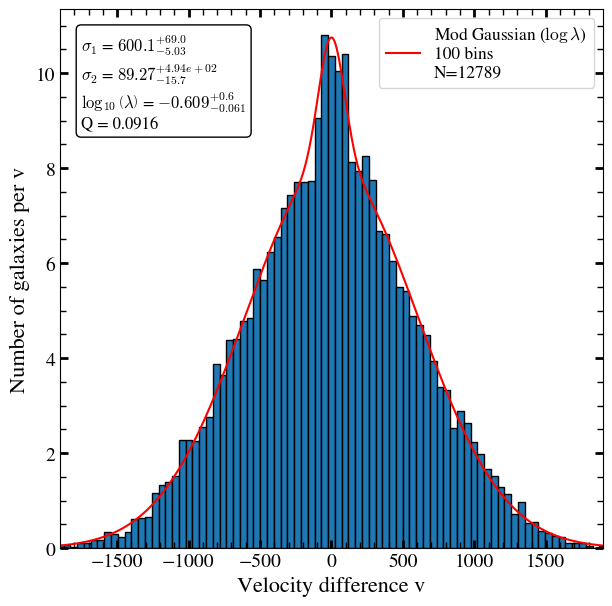

46


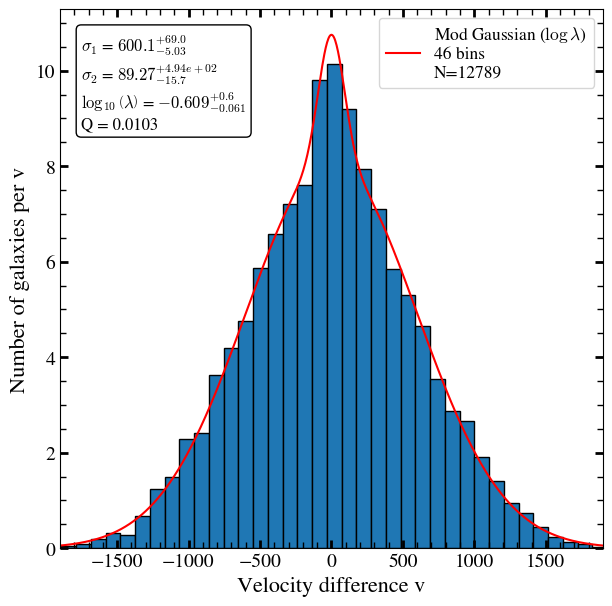

In [3]:
reload(ONEHALO)
massbin = '14.0-14.5'
rbin = '0.10-0.13'

LL_paramfile = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_{massbin}/r_{rbin}_log_lambda.json'
with open(LL_paramfile) as handle:
    params_LL = json.load(handle)

paramfile = f'/disks/cosmodm/vdvuurst/data/OneHalo_param_fits/emcee/M_{massbin}/r_{rbin}.json'
with open(paramfile) as handle:
    params = json.load(handle)

datafile = f'/disks/cosmodm/vdvuurst/data/OneHalo_0.5dex/M_{massbin}/r_{rbin}.hdf5'
with h5py.File(datafile) as handle:
    data = handle['rel_vels'][:].flatten()
    data.sort()

log_lambda_plot = lambda x: plot_distribution_gaussian_mod(mod_gaussian_loglambda, params_LL, data, x, r'Mod Gaussian ($\log \lambda$)' + f'\n{x} bins', show = True, loglambda = True)
stnd_plot = lambda x: plot_distribution_gaussian_mod(mod_gaussian, params, data, x, r'Mod Gaussian', show = True)

log_lambda_plot(100)
print(2 * int(np.cbrt(data.size)))
log_lambda_plot(2 * int(np.cbrt(data.size)))

### Removing certain bad bins to see their impact

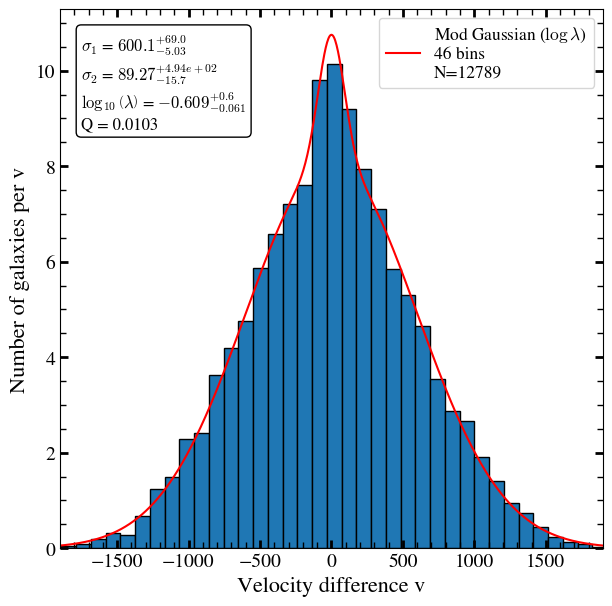

sum(model) = np.float64(12787.953708662568), sum(bin_heights) = np.int64(12789)
Gval = np.float64(158.66019572188478)


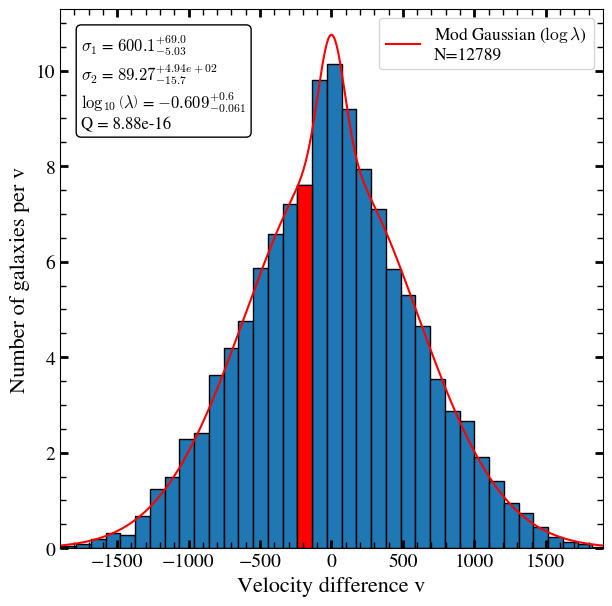

sum(model) = np.float64(12787.953708662568), sum(bin_heights) = np.int64(12789)
Gval = np.float64(129.2517716838464)


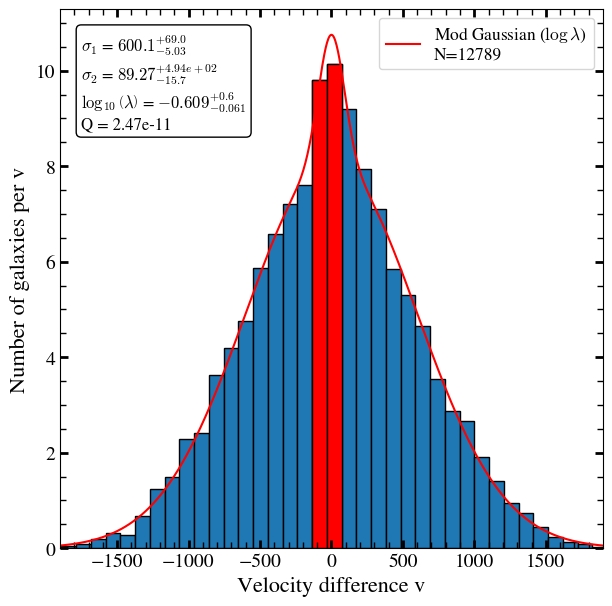

sum(model) = np.float64(12787.953708662568), sum(bin_heights) = np.int64(12789)
Gval = np.float64(98.78205424650321)


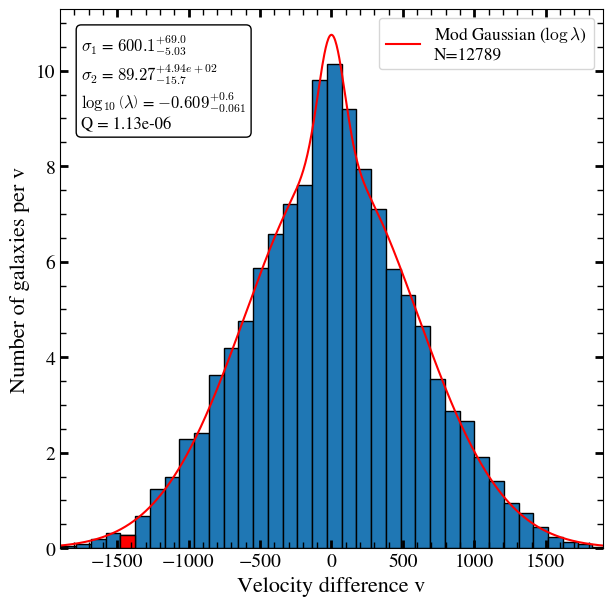

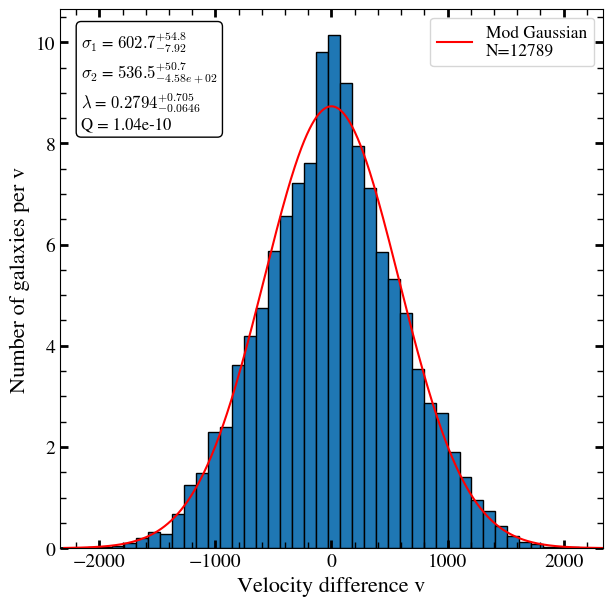

sum(model) = np.float64(12788.090107316712), sum(bin_heights) = np.int64(12789)
Gval = np.float64(262.7859765059796)


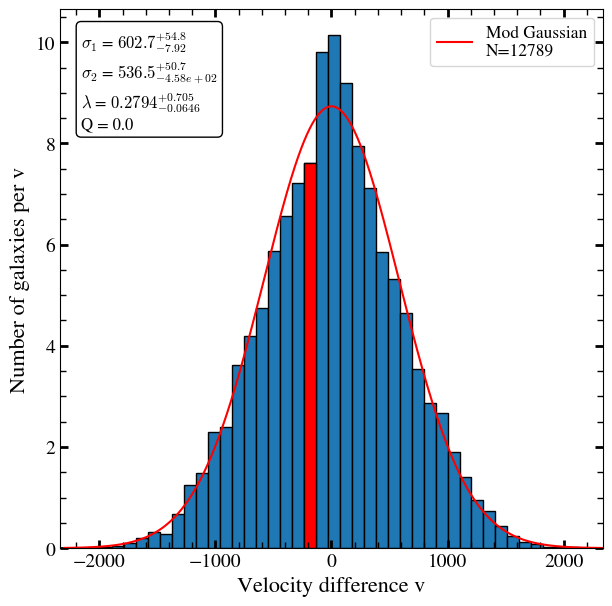

In [5]:
from functions import _Gstat, _Qval

def mod_get_Qvalue(param_dict, bin_heights, bin_edges, skip_bins = [], integral_func = mod_gaussian_integral, sanitycheck = True):
    no_skip_idx = np.arange(bin_heights.size)
    no_skip_idx = no_skip_idx[np.invert(np.isin(no_skip_idx, skip_bins))]

    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    hist_area=np.sum(bin_heights)

    model = hist_area * np.array([integral_func(param_dict['sigma_1'], param_dict['sigma_2'], param_dict['lambda'],
                                                               bin_edges[i], bin_edges[i+1]) for i in range(len(bin_centers))])
    
    Gval = _Gstat(bin_heights[no_skip_idx], model[no_skip_idx]) 
    if sanitycheck:
        print(f"{sum(model) = }, {sum(bin_heights) = }")
        print(f'{Gval = }')
    #dof = 4 since three parameters and 1 extra less since if N -1 bins are filled we know exactly the Nth bin count
    return _Qval(Gval, len(bin_heights) - 4 - len(skip_bins))


def mod_plot_distribution_gaussian_mod(func, param_dict,data,bins, bins_to_remove = [], distname = 'Mod Gaussian', filename = 'Mfit', show = False, loglambda = False, sanitycheck = False):
    sigma1, sigma2, lambda_ = param_dict['sigma_1'], param_dict['sigma_2'], param_dict['lambda']
    # Set plot appeareance
    fig = plt.figure(figsize=(7,7))
    frame=fig.add_subplot(1,1,1)
    frame.set_xlabel('Velocity difference v', fontsize=16)
    frame.set_ylabel('Number of galaxies per v', fontsize=16)
    frame.tick_params(axis='both', which='major',length=6, width=2,labelsize=14)

    if loglambda:
        weighted_sigma = np.average([sigma1, sigma2], weights = [1-10**(lambda_), 10**(lambda_)])
        if sanitycheck:
            print(f'{4*weighted_sigma = }')
    else:
        weighted_sigma = np.average([sigma1, sigma2], weights = [1- lambda_, lambda_])

    # range_mask = (data >= -4 * weighted_sigma) & (data <= 4 * weighted_sigma)
    # data = data[range_mask]

    bin_heights, bin_edges = np.histogram(data, bins=bins, density=False)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_width= bin_edges[1] - bin_edges[0] 
    bin_widths = np.diff(bin_edges)  # The width of each bin
    number_density = bin_heights / bin_widths  # Normalize by bin width


    frame.bar(bin_centers, number_density, width=bin_width, align='center', edgecolor = 'black')
    frame.bar(bin_centers[bins_to_remove], number_density[bins_to_remove], width=bin_width, align='center', edgecolor = 'black', facecolor = 'red')
    DAT=np.linspace(np.min(data),np.max(data),1000)

    usemask = np.invert(np.isin(np.arange(bins), bins_to_remove))

    # Creating textbox for parameter values
    paramstr = ''
    sig_digits = 4
    for i,param in enumerate(['sigma_1', 'sigma_2', 'lambda']):
        if i == 2 and loglambda:
            param_latex = 'log' + param
            sig_digits = 3
        else:
            param_latex = param

        paramstr += latex_formatter[param_latex] + f' = ${param_dict[param]:.{sig_digits}}^{{+{param_dict['errors'][i][1]:.{sig_digits -1}}}}_{{-{param_dict['errors'][i][0]:.{sig_digits -1}}}}$\n'
    
    # Calculating Q-values for goodness of fit estimate
    integral_func = mod_gaussian_integral if not loglambda else mod_gaussian_integral_loglambda
    Qval = mod_get_Qvalue(param_dict, bin_heights, bin_edges, skip_bins=bins_to_remove, integral_func = integral_func, sanitycheck = True)

    #Update textbox w/ Q and plot
    paramstr += f'Q = {Qval:.3}'
    frame.text(0.155, 0.71, paramstr, transform=plt.gcf().transFigure, backgroundcolor='white',zorder=-1, bbox = {'boxstyle':'round','facecolor':'white'}, fontsize = 12)

    hist_area=np.sum(bin_heights)
    frame.plot(DAT,hist_area*func(DAT,sigma1,sigma2,lambda_),'-', label=f"{distname}\nN={hist_area:.0f}",color='red')

    frame.legend(fontsize=12.5, loc="upper right")

    frame.set_xlim(-4 * weighted_sigma, 4 * weighted_sigma)
    
    if not show:
        fig.savefig(filename, dpi=200)
        plt.close()
    else:
        plt.show()


log_lambda_plot(46)
mod_plot_distribution_gaussian_mod(mod_gaussian_loglambda, params_LL, data, 46, [20], r'Mod Gaussian ($\log \lambda$)', show = True, loglambda = True)
mod_plot_distribution_gaussian_mod(mod_gaussian_loglambda, params_LL, data, 46, [21,22], r'Mod Gaussian ($\log \lambda$)', show = True, loglambda = True)
mod_plot_distribution_gaussian_mod(mod_gaussian_loglambda, params_LL, data, 46, [8], r'Mod Gaussian ($\log \lambda$)', show = True, loglambda = True)

stnd_plot(46)
mod_plot_distribution_gaussian_mod(mod_gaussian, params, data, 46,[20], r'Mod Gaussian', show = True)